In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from time import sleep
from matplotlib.animation import FuncAnimation
from matplotlib.patches import RegularPolygon
from matplotlib.collections import PatchCollection
from math import sin, cos, atan2, sqrt, pi

In [3]:
def wrap_to_pi(theta):
    return (theta + pi) % (2 * pi) - pi

In [4]:
class Robot(object):
    '''A differential drive robot living in the x, y, theta plane'''
    
    def __init__(self, init_pose=np.zeros(3)):
        self.pose = init_pose 
        self.patch = RegularPolygon(xy=init_pose[:2], numVertices=3, 
                                    radius=0.1, orientation=init_pose[2] - pi / 2)
   
    def update_pose(self, v, w, dt=0.1):
        dx = dt * v * cos(self.pose[2])
        dy = dt * v * sin(self.pose[2])
        dtheta = dt * w
        
        self.pose += np.array([dx, dy, dtheta])
        self.patch._xy += np.array([dx, dy])
        self.patch._orientation += dtheta

In [38]:
class RobotControl(object):
    k_alpha = 1
    k_beta = -0.5
    k_rho = 0.1
    
    def __init__(self, goal_pose=np.zeros(3)):
        self.goal_pose = goal_pose
        self.patch = RegularPolygon(xy=goal_pose[:2], numVertices=3, 
                                    radius=0.1, orientation=goal_pose[2] - pi / 2)
    
    def control_law(self, measured_pose):
        e = self.goal_pose - measured_pose
        dx, dy = e[0], e[1]
        theta = wrap_to_pi(measured_pose[2])

        rho = sqrt(dx**2 + dy**2)
        alpha = wrap_to_pi(-theta + atan2(dy, dx))
        beta = wrap_to_pi(-theta - alpha)

        v = self.k_rho * rho
        w = self.k_alpha * alpha + self.k_beta * beta
        
        if alpha < -pi / 2 or alpha > pi / 2:
            v, w = -v, -w
        
        return v, w

In [16]:
def get_limits(init_pose, goal_pose):
    x_min = min(init_pose[0], goal_pose[0]) - 1
    x_max = max(init_pose[0], goal_pose[0]) + 1

    y_min = min(init_pose[1], goal_pose[1]) - 1
    y_max = max(init_pose[1], goal_pose[1]) + 1
    return [x_min, x_max, y_min, y_max]

In [9]:
def configure_axes(ax, init_pose, goal_pose):
    limits = get_limits(init_pose, goal_pose)
    ax.set_xlim(limits[:2])
    ax.set_ylim(limits[2:])
    
    ax.set_xlabel('$ x $')
    ax.set_ylabel('$ y $')
    ax.set_title('Trajectory')

<IPython.core.display.Javascript object>


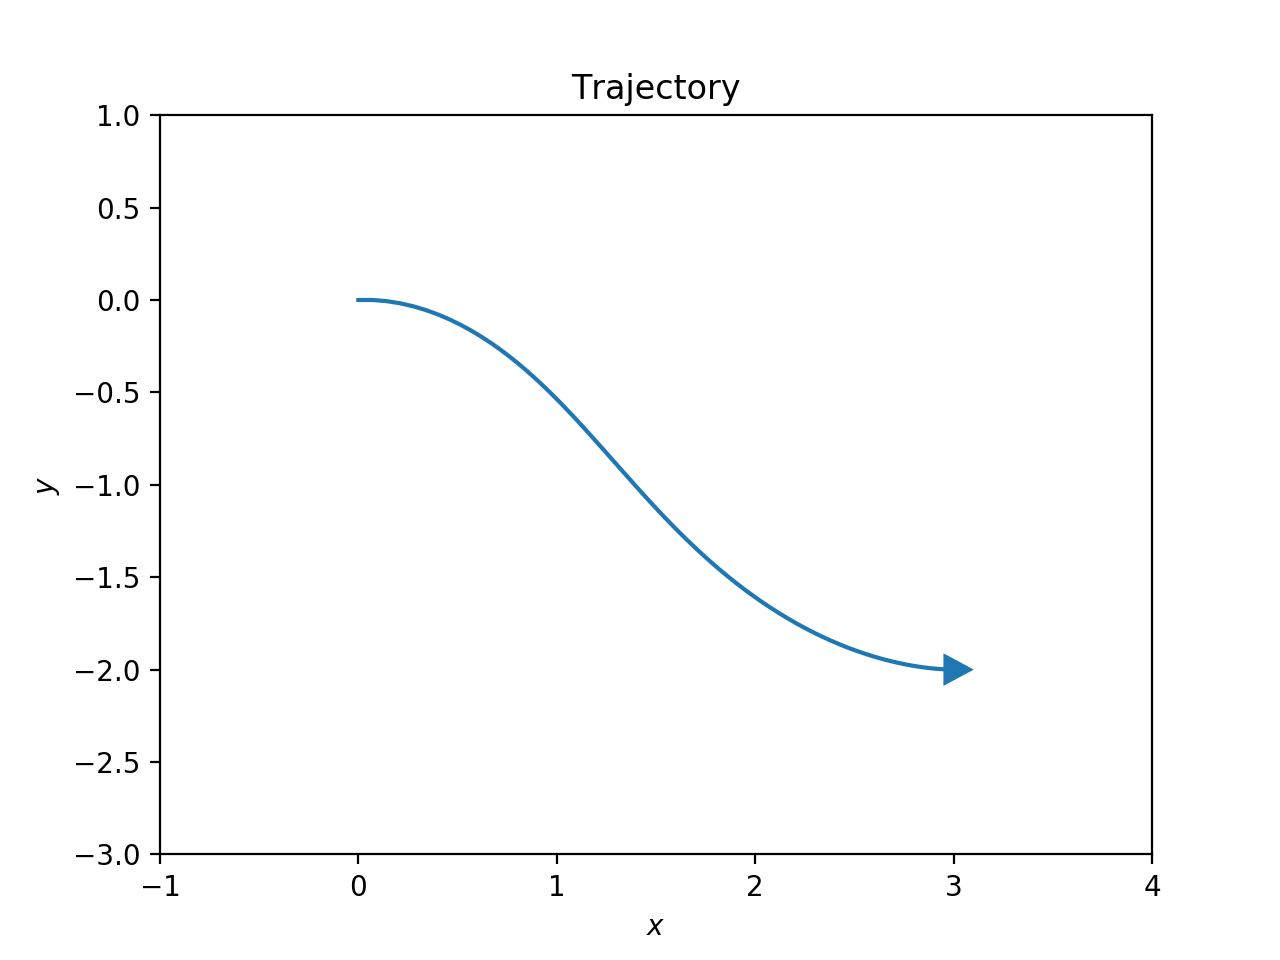

In [42]:
init_pose = np.array(np.zeros(3))
goal_pose = np.array([3, 3, 0])

xdata, ydata = [], []

robot = Robot(init_pose)
controller = RobotControl(goal_pose)

f, ax = plt.subplots()
configure_axes(ax, init_pose, goal_pose)

history, = ax.plot(xdata, ydata)
ax.add_patch(robot.patch)
ax.add_patch(controller.patch)

plt.show()

def init():
    pass

def advance(i):
    global xdata, ydata
    measured_pose = robot.pose
    xdata += [measured_pose[0]]
    ydata += [measured_pose[1]]
    v, w = controller.control_law(measured_pose)
    robot.update_pose(v, w)
    history.set_data(xdata, ydata)   

FuncAnimation(fig=f, func=advance, init_func=init, frames=500, interval=10, repeat=False, blit=True)